In [1]:
import numpy as np 
# linear algebra
import pandas as pd 
# data processing, CSV file I/O (e.g. pd.read_csv)
import os
#写入当前目录的任何结果都将保存为输出。

import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import model_from_json
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.backend import clear_session

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import Sequence
from PIL import Image

from tensorflow.python.keras.utils.np_utils import to_categorical

import random
import math
import pandas as pd
import numpy as np
from tensorflow.python.keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2

d:\Anaconda3\envs\tf_2.4\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = './CK+48'
data_dir_list = os.listdir(data_path)

In [3]:
data_dir_list

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

In [4]:
num_epoch=10

img_data_list=[]

for dataset in data_dir_list:
    img_list=os.listdir(data_path+'/'+ dataset)
    print ('Loaded the images of dataset-'+'{}\n'.format(dataset))
    for img in img_list:
        input_img=cv2.imread(data_path + '/'+ dataset + '/'+ img )
        #input_img=cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
        input_img_resize=cv2.resize(input_img,(48,48))
        img_data_list.append(input_img_resize)


Loaded the images of dataset-anger

Loaded the images of dataset-contempt

Loaded the images of dataset-disgust

Loaded the images of dataset-fear

Loaded the images of dataset-happy

Loaded the images of dataset-sadness

Loaded the images of dataset-surprise



In [5]:
    
img_data = np.array(img_data_list)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

(981, 48, 48, 3)

In [6]:
#图片有七个类型
num_classes = 7

num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:134]=0 #135
labels[135:188]=1 #54
labels[189:365]=2 #177
labels[366:440]=3 #75
labels[441:647]=4 #207
labels[648:731]=5 #84
labels[732:980]=6 #249

names = ['anger','contempt','disgust','fear','happy','sadness','surprise']

def getLabel(id):
    return ['anger','contempt','disgust','fear','happy','sadness','surprise'][id]

In [7]:
from sklearn.utils import shuffle

In [8]:
#
Y = to_categorical(labels, num_classes)

#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)
x_test=X_test

In [9]:
X_train.shape

(784, 48, 48, 3)

In [10]:
INIT_LR = 0.01
EPOCHS = 50
BS = 64

# VGG

In [11]:
#定义卷积神经网络VGG
def get_vgg(classes=7):
    #在进行keras的交叉验证时，清空session否则上一折的训练集成了这一折的验证集，数据泄露
    #clear_session()
    #序列模型，逐层添加网络
    model=Sequential()
    #输入维度
    input_shape = (48,48,3)

    model.add(Conv2D(64, (3, 3), input_shape=input_shape,activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    #BatchNormalization批标准化减少梯度消失，加快了收敛过程。起到类似dropout一样的正则化能力，一定程度上防止过拟合。
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(256, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(512, (3, 3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))

    #对多维数据的降维函数，将数据转为一维
    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(classes))
    #softmax一般用于多分类的结果，一般和one-hot的真实标签值配合使用，大多数用于网络的最后一层；
    model.add(Activation('softmax'))
    #decay每次更新后的学习率衰减值
    opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    #多分类的对数损失函数，与softmax分类器相对应的损失函数，optimizer优化器，metrics指标
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)
    
#打印出网络的结构和参数统计
    model.summary()
    return model
model = get_vgg()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       1

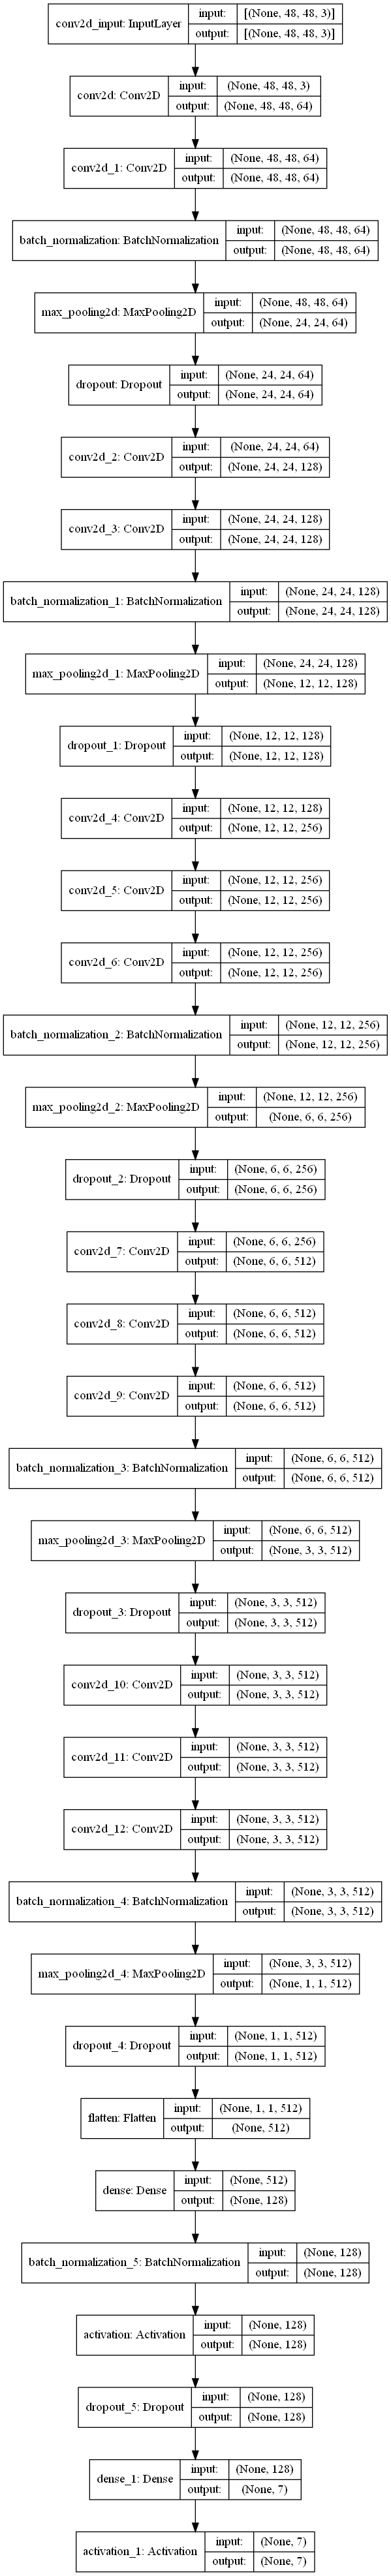

In [13]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='ck_VGG.png', show_shapes=True,show_layer_names=True)
Image(filename='ck_VGG.png') 

In [108]:
ck_vgg_history = model.fit(
            x=X_train,
            y=y_train,
            #data_generator(batch_size, y_train, train_data),
            batch_size=BS,
            #steps_per_epoch=steps, 
            #训练次数
            epochs=50,
            #显示训练过程
            verbose=1,

            validation_data=(X_test,y_test),

            shuffle=True,
           )

Epoch 1/50
13/13 [==============================] - 1s 47ms/step - loss: 2.3252 - accuracy: 0.1276 - val_loss: 2.0001 - val_accuracy: 0.0457
Epoch 2/50
13/13 [==============================] - 0s 35ms/step - loss: 2.0482 - accuracy: 0.2092 - val_loss: 2.0224 - val_accuracy: 0.1878
Epoch 3/50
13/13 [==============================] - 0s 35ms/step - loss: 1.9006 - accuracy: 0.2921 - val_loss: 2.0257 - val_accuracy: 0.0457
Epoch 4/50
13/13 [==============================] - 0s 35ms/step - loss: 1.7582 - accuracy: 0.3622 - val_loss: 2.0289 - val_accuracy: 0.0457
Epoch 5/50
13/13 [==============================] - 0s 36ms/step - loss: 1.5065 - accuracy: 0.4554 - val_loss: 2.0420 - val_accuracy: 0.0457
Epoch 6/50
13/13 [==============================] - 0s 36ms/step - loss: 1.4276 - accuracy: 0.5000 - val_loss: 2.1156 - val_accuracy: 0.0457
Epoch 7/50
13/13 [==============================] - 0s 36ms/step - loss: 1.2827 - accuracy: 0.5344 - val_loss: 2.1820 - val_accuracy: 0.0457
Epoch 8/50
13

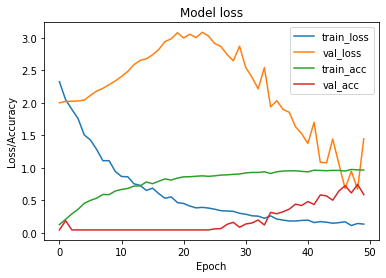

In [109]:
N = np.arange(0, 50)
plt.plot(N,ck_vgg_history.history['loss'],label="train_loss")
plt.plot(N,ck_vgg_history.history['val_loss'],label="val_loss")
plt.plot(N,ck_vgg_history.history['accuracy'],label="train_acc")
plt.plot(N,ck_vgg_history.history['val_accuracy'],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

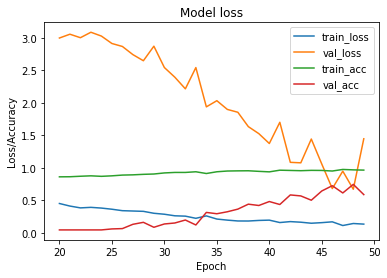

In [114]:
N = np.arange(20, 50)
plt.plot(N,ck_vgg_history.history['loss'][20:50],label="train_loss")
plt.plot(N,ck_vgg_history.history['val_loss'][20:50],label="val_loss")
plt.plot(N,ck_vgg_history.history['accuracy'][20:50],label="train_acc")
plt.plot(N,ck_vgg_history.history['val_accuracy'][20:50],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# 胶囊

In [14]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer

In [15]:
"""
压缩函数,使用0.5替代1,如果是1，所有的向量的范数都将被缩小。
如果是0.5，小于0.5的范数将缩小，大于0.5的将被放大
"""
def squash(x, axis=-1):
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm)/ (0.5 + s_squared_norm)
    return scale * x


"""
定义我们自己的softmax函数，而不是K.softmax.因为K.softmax不能指定轴
因为在后面的步骤中，轴发生了交换，因此需要特别指定softmax轴，其余的与softmax一样
"""
def softmax(x, axis=-1):
    ex = K.exp(x - K.max(x, axis=axis, keepdims=True))
    return ex/K.sum(ex, axis=axis, keepdims=True)

In [16]:
#A Capsule Implement with Pure Keras

class Capsule(Layer):
    """编写自己的Keras层需要重写3个方法以及初始化方法
    1.build(input_shape):这是你定义权重的地方。
    这个方法必须设self.built = True，可以通过调用super([Layer], self).build()完成。
    2.call(x):这里是编写层的功能逻辑的地方。
    你只需要关注传入call的第一个参数：输入张量，除非你希望你的层支持masking。
    3.compute_output_shape(input_shape):
     如果你的层更改了输入张量的形状，你应该在这里定义形状变化的逻辑，这让Keras能够自动推断各层的形状。
    4.初始化方法,你的神经层需要接受的参数
    """ 
    #num_capsule胶囊数量  dim_capsule胶囊尺寸  routings动态路由迭代次数  
    def __init__(self, num_capsule, dim_capsule, routings=3, share_weights=True, activation='squash', **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation) #得到激活函数
    #定义权重
    def build(self, input_shape):
         # 必须继承Layer的build方法
        super(Capsule, self).build(input_shape)
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            #自定义权重
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1, input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
        else:
            #自定义权重
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule * self.dim_capsule),
                                     initializer='glorot_uniform',
                                     trainable=True)
 # 层的功能逻辑(核心)
    def call(self, u_vecs):
        if self.share_weights:
             # 用一维卷积替代类似的全连接层
            u_hat_vecs = K.conv1d(u_vecs, self.W)
        else:
            #未共享权重的conv1d
            u_hat_vecs = K.local_conv1d(u_vecs, self.W, [1], [1])
    
        #批次数目
        batch_size = K.shape(u_vecs)[0]
        #输入胶囊的个数
        input_num_capsule = K.shape(u_vecs)[1]
        
        u_hat_vecs = K.reshape(u_hat_vecs, (batch_size, input_num_capsule,
                                            self.num_capsule, self.dim_capsule))
        # 交换轴
        u_hat_vecs = K.permute_dimensions(u_hat_vecs, (0, 2, 1, 3))
        #final u_hat_vecs.shape = [None, num_capsule, input_num_capsule, dim_capsule]
	    # 动态路由算法更新b
         # 步骤1，初始化为0
        b = K.zeros_like(u_hat_vecs[:,:,:,0]) 
        # 迭代步骤2-5 r次 
        for i in range(self.routings):
            c = softmax(b, 1)# 步骤2，softmax
            o = tf.einsum('bin,binj->bij', c, u_hat_vecs)# 步骤3，批量矩阵相乘
            if K.backend() == 'theano': # 步骤4
                o = K.sum(o, axis=1)
            if i < self.routings-1:
                o = K.l2_normalize(o, -1)
                # b = K.batch_dot(o, u_hat_vecs, [2, 3])
                b = tf.einsum('bij,binj->bin', o, u_hat_vecs)
                if K.backend() == 'theano':
                    b = K.sum(b, axis=1)

            # c = softmax(b, 1)# 步骤2，softmax
            # s = K.batch_dot(c, u_hat_vecs, [2, 2])  # 步骤3，批量矩阵相乘
            # o = self.activation(s)  # 步骤4
            # if i < self.routings - 1:
            #     b += K.batch_dot(o, u_hat_vecs, [2, 3])  # 步骤5
               
        return self.activation(o)
     # 自动推断shape
    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)


In [17]:
def get_Capsule(classes=7):
    clear_session()

    input_image = Input(shape=(48,48,3))
    x = Conv2D(64, (3, 3), input_shape=(48,48,1),activation='relu', padding='same')(input_image)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3),activation='relu',padding='same')(x)
    x = Conv2D(128, (3, 3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(256, (3, 3),activation='relu',padding='same')(x)
    x = Conv2D(256, (3, 3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3),activation='relu',padding='same')(x)
    x = Conv2D(512, (3, 3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(512, (3, 3),activation='relu',padding='same')(x)
    x = Conv2D(512, (3, 3),activation='relu',padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    cnn = Reshape((-1, 128))(x)
    capsule = Capsule(10, 25, 3, False)(cnn)

    x = Flatten()(capsule)
    
    output =  Dense(classes,activation='softmax')(x)

    model = Model(inputs=input_image, outputs=output)
	
    #optim = optim.SGD(parameters(), lr=INIT_LR, weight_decay=1e-2)
    opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

    model.summary()
    return model
model = get_Capsule()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856 

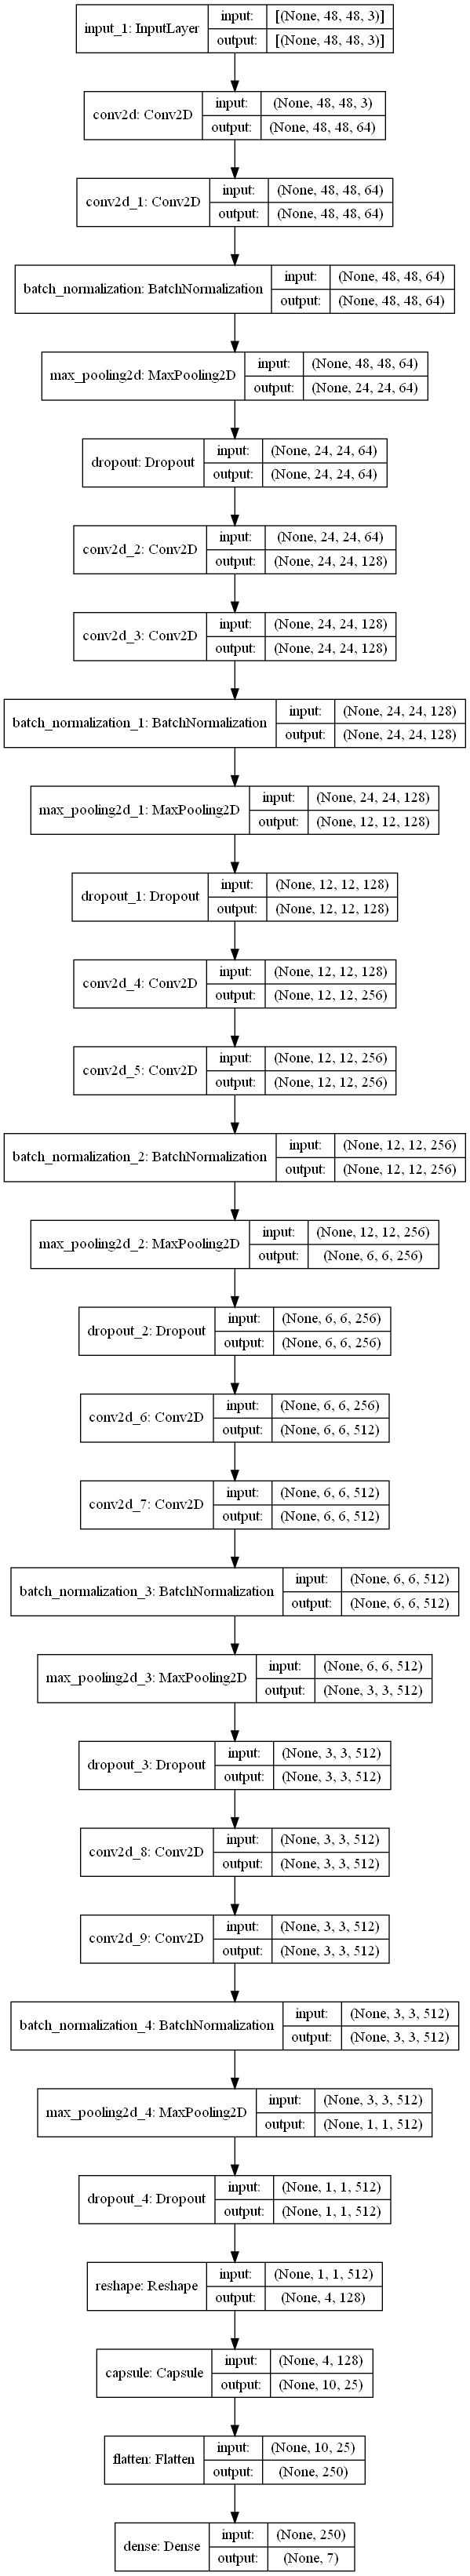

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='ck_Capsule.png', show_shapes=True,show_layer_names=True)
Image(filename='ck_Capsule.png') 

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint
ck_capsule_history = model.fit(
            x=X_train,
            y=y_train,
            #data_generator(batch_size, y_train, train_data),
            batch_size=BS,
            #steps_per_epoch=steps, 
            #训练次数
            epochs=80,
            #显示训练过程
            verbose=1,

            validation_data=(X_test,y_test),

            shuffle=True, )

Epoch 1/80
13/13 [==============================] - 1s 65ms/step - loss: 0.4745 - accuracy: 0.8992 - val_loss: 1.1069 - val_accuracy: 0.5787
Epoch 2/80
13/13 [==============================] - 1s 68ms/step - loss: 0.4618 - accuracy: 0.9082 - val_loss: 0.9711 - val_accuracy: 0.6396
Epoch 3/80
13/13 [==============================] - 1s 58ms/step - loss: 0.4387 - accuracy: 0.9107 - val_loss: 0.8408 - val_accuracy: 0.6599
Epoch 4/80
13/13 [==============================] - 1s 40ms/step - loss: 0.4408 - accuracy: 0.9069 - val_loss: 0.8465 - val_accuracy: 0.7005
Epoch 5/80
13/13 [==============================] - 1s 62ms/step - loss: 0.4175 - accuracy: 0.9260 - val_loss: 0.9197 - val_accuracy: 0.6497
Epoch 6/80
13/13 [==============================] - 1s 51ms/step - loss: 0.4083 - accuracy: 0.9209 - val_loss: 0.8822 - val_accuracy: 0.6599
Epoch 7/80
13/13 [==============================] - 1s 44ms/step - loss: 0.4198 - accuracy: 0.9184 - val_loss: 0.5647 - val_accuracy: 0.8274
Epoch 8/80
13

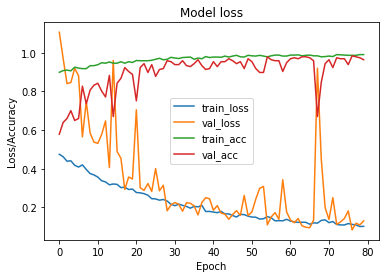

In [21]:
N = np.arange(0, 80)
plt.plot(N,ck_capsule_history.history['loss'],label="train_loss")
plt.plot(N,ck_capsule_history.history['val_loss'],label="val_loss")
plt.plot(N,ck_capsule_history.history['accuracy'],label="train_acc")
plt.plot(N,ck_capsule_history.history['val_accuracy'],label="val_acc")
plt.title('Model loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# ResNet

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
#import skimage.io
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [11]:
base_model = tf.keras.applications.ResNet50(
     input_shape=(48,48,3),
     include_top=False,
     weights="imagenet"
)

In [12]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [13]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))
opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=opt)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 2048)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dense (Dense)                (None, 32)                262176    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0

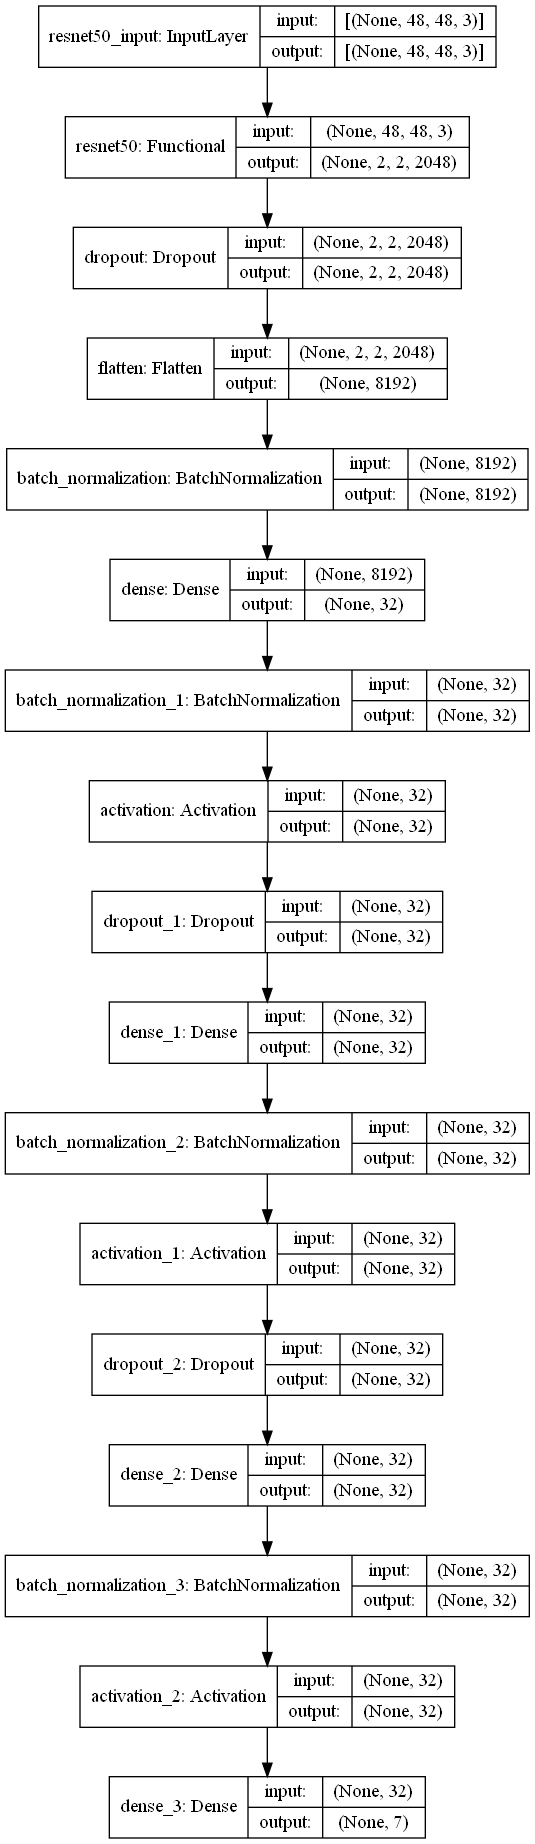

In [14]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [15]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
       # f1_score,
]

In [16]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

In [17]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

In [18]:
history=model.fit(
    x=X_train,
    y=y_train,
    batch_size=BS,
    validation_data=(X_test,y_test),
    epochs = 60,
    verbose = 1,
    shuffle=True
    #callbacks=[lrd,mcp,es]
    )

Epoch 1/60
13/13 [==============================] - 8s 120ms/step - loss: 2.0532 - accuracy: 0.8497 - precision: 0.2530 - recall: 0.0268 - auc: 0.5691 - val_loss: 1.8337 - val_accuracy: 0.8586 - val_precision: 1.0000 - val_recall: 0.0102 - val_auc: 0.6761
Epoch 2/60
13/13 [==============================] - 0s 20ms/step - loss: 1.8564 - accuracy: 0.8562 - precision: 0.4699 - recall: 0.0497 - auc: 0.6448 - val_loss: 1.8432 - val_accuracy: 0.8716 - val_precision: 0.6190 - val_recall: 0.2640 - val_auc: 0.6829
Epoch 3/60
13/13 [==============================] - 0s 19ms/step - loss: 1.7400 - accuracy: 0.8628 - precision: 0.6632 - recall: 0.0804 - auc: 0.6967 - val_loss: 1.6931 - val_accuracy: 0.8782 - val_precision: 0.7042 - val_recall: 0.2538 - val_auc: 0.7064
Epoch 4/60
13/13 [==============================] - 0s 20ms/step - loss: 1.6863 - accuracy: 0.8666 - precision: 0.7203 - recall: 0.1084 - auc: 0.7164 - val_loss: 1.6581 - val_accuracy: 0.8796 - val_precision: 0.7246 - val_recall: 0.25

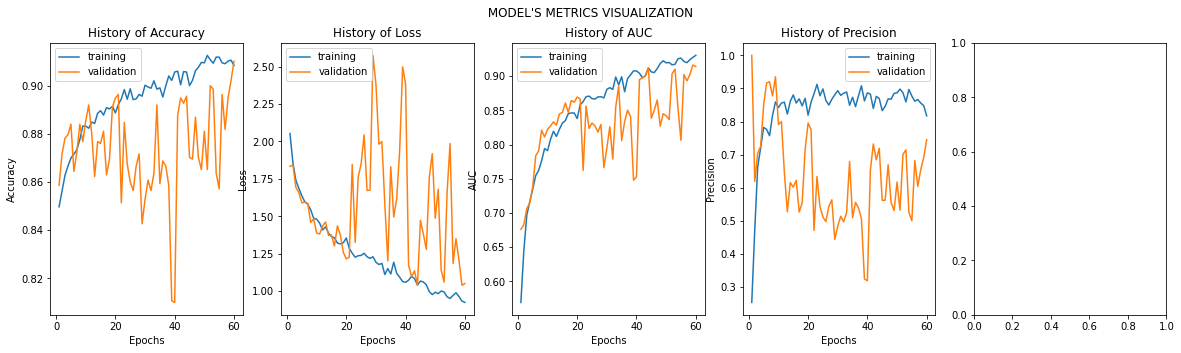

In [19]:
#%% PLOTTING RESULTS (Train vs Validation FOLDER 1)

def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    # ax5.plot(range(1, len(f1) + 1), f1)
    # ax5.plot(range(1, len(val_f1) + 1), val_f1)
    # ax5.set_title('History of F1-score')
    # ax5.set_xlabel('Epochs')
    # ax5.set_ylabel('F1 score')
    # ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               #history.history['f1_score'],history.history['val_f1_score']
              )